Load Julia packages (libraries) needed  for the snippets in chapter 0

In [1]:
using StatisticalRethinking, CmdStan, StanMCMCChain, LinearAlgebra
gr(size=(500,500));

CmdStan uses a tmp directory to store the output of cmdstan

In [2]:
ProjDir = rel_path("..", "scripts", "04")
cd(ProjDir)

### snippet 4.7

In [3]:
howell1 = CSV.read(rel_path("..", "data", "Howell1.csv"), delim=';')
df = convert(DataFrame, howell1);

Use only adults

In [4]:
df2 = filter(row -> row[:age] >= 18, df);
first(df2, 5)

,height,weight,age,male
,Float64⍰,Float64⍰,Float64⍰,Int64⍰
1,151.765,47.8256,63.0,1
2,139.7,36.4858,63.0,0
3,136.525,31.8648,65.0,0
4,156.845,53.0419,41.0,1
5,145.415,41.2769,51.0,0


Use data from m4.1s

Check if the m4.1s.jls file is present. If not, run the model.

In [5]:
!isfile(joinpath(ProjDir, "m4.1s.jls")) && include(joinpath(ProjDir, "m4.1s.jl"))

chn = deserialize(joinpath(ProjDir, "m4.1s.jls"))

Object of type "Chains{Float64}"

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Union{Missing, Float64}[7.98958 154.745; 7.97613 154.757; … ; 7.84049 154.497; 8.00805 154.679]

Union{Missing, Float64}[7.94933 154.229; 7.52199 155.054; … ; 7.9072 153.782; 7.85663 153.812]

Union{Missing, Float64}[7.1697 154.695; 8.42094 154.331; … ; 7.76955 154.415; 7.82586 154.548]

Union{Missing, Float64}[7.22598 154.436; 7.19645 154.509; … ; 8.00677 154.367; 8.30892 155.324]

Describe the draws

In [6]:
describe(chn)

Iterations = 1:1000
Thinning interval = 1
Chains = 1,2,3,4
Samples per chain = 1000

Empirical Posterior Estimates:
         Mean        SD       Naive SE       MCSE     ESS
sigma   7.765263 0.29244676 0.0046239893 0.004765301 1000
   mu 154.589085 0.41872458 0.0066206169 0.007877353 1000

Quantiles:
         2.5%       25.0%      50.0%      75.0%       97.5%  
sigma   7.221306   7.5524275   7.76204   7.9645775   8.354744
   mu 153.747975 154.3030000 154.59200 154.8730000 155.388025



Plot the density of posterior draws

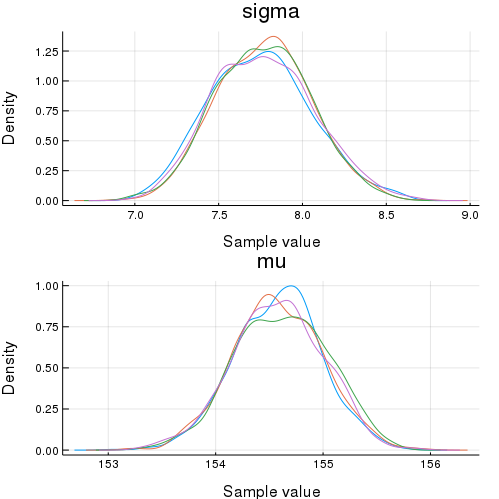

In [7]:
density(chn, lab="All heights", xlab="height [cm]", ylab="density")

Compute cor

In [8]:
mu_sigma = hcat(chn.value[:, 2, 1], chn.value[:,1, 1])
LinearAlgebra.diag(cov(mu_sigma))

2-element Array{Float64,1}:
 0.16083226586186197
 0.09243858293126567

Compute cov

In [9]:
cor(mu_sigma)

2×2 Array{Float64,2}:
  1.0        -0.0209048
 -0.0209048   1.0      

End of `clip_07.0s.jl`

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*